# Living Coasts Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Viewing above ground biomass datasets

This notebooks allows you to use an interactive map to extract woody above ground biomass (AGB) data generated by the European Space Agency (ESA) Climate Change Initiative (CCI) Biomass Project (https://climate.esa.int/en/projects/biomass/).  

The above ground biomass (AGB) estimates for vegetation are generally expresssed in tonnes per hectare or Mg ha^-1 and those generated from Earth observation data are largely associated with the above ground components (leaves, branches and trunks). The below ground biomass (held within the fine and coarse roots) is generally inferred (e.g., from ratios determined from ground-based measurements).   

The ESA CCI Biomass project has recently generated eight maps of AGB globally at 100 m spatial resolution (equivalent to 1 ha) for 2010 and annually from 2015 to 2021 from time-series of C-band SAR (ENVISAT Advanced Synthetic Aperture Radar (SAR) and the Japan Aerospace Exploration Agency's (JAXA) L-band SAR.   Details of the algorithm used for retrieval are given in the paper by [Santoro et al. (2024)](https://www.sciencedirect.com/science/article/pii/S2666017224000531).

## Description 

The notebook will demonstrate how you can view above ground biomass data generated from a combination of time-series of spaceborne C-band and L-band radar data.  Spatial uncertainty maps are provided with these quantifying the standard deviation of the estimate.  
The notebooks take you through the process of:

1. Identifying an area interactively using a rectangle, polygon drawn freehand or a loaded vector file, noting that the AGB datasets are currently provided for coastal Queensland in this notebook (select southeast Queensland)
2. Extracting the AGB estimate for each year (2010 and annually from 2015 to 2021) and the associated standard deviation of the AGB for the area of interest. 
3. Viewing the AGB maps for each year and associated standard deviations.
4. Viewing the land cover maps for a selected period (any time from 1988 to the present) for the same area.

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

In [1]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


added a new line here
another line


## Section 2 Select your area of interest
Here, select the geojson file for Fraser Island in Queensland which you do by using the "Load" tab in the map explorer.  You can also choose any area on Fraser Island using the 'draw' method.   Select the file 'FraserIs_box.geoson' from the uploads/AOI folder. You will then load and wait for the coordinates to appear. Once this occurs, you can go to the next cell.

In [2]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


89

## Section 3:  Select the time-period for the land cover maps
The maps of AGB have been generated for 2010 and annually from 2025 to 2021.  
You can observe the changes in land cover for this area from 1988 to 2020 but it suggested to use from 2010 to 2020 in the first instance.  This information can help in your interpretation of the changing amounts of AGB in each year. 

In [3]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


## Load the land cover classifications from the data cube
Here, you will load a range of environmental descriptors generated from Earth observation data (including lifeform, vegetation cover, water seasonality, water state, seasonality and persistence) and the full classifications constructed from these for each year through *Living Earth*

In [4]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-24.87170750180394, -24.69475695206158)
Lon Range: (153.08866673068707, 153.28460443197065)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-24.87170750180394, -24.69475695206158), 'x': (153.08866673068707, 153.28460443197065), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UN

## Loading ESA CCI Biomass datasets (2010 and annually from 2015-2021)
The cell below allows you to select the AGB and standard deviation (SD) datasets based on the area of interest.  Here, the data for Fraser Island are associated with the 1 degree tile with latitude South 20-30 degrees and longitude 140-150 degrees (i.e., S20E150). Other datasets can be uploaded for other degree tiles (as indicated - e.g., S30E120).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
from pyproj import CRS
from rasterio.warp import Resampling
import datetime
import os

# Define the folder paths
base_paths = {
    "S20E150": "./uploads/AGB/S20E150_Qld_SEast/",
    "S10E140": ".uploads/AGB/S10E140_Qld_North/",
    "S30E110": ".uploads/AGB/S30E110_WA_SWest/",
    "S30E120": ".uploads/AGB/S30E120_WA_SEast/"
}

# Define the file naming formats
file_formats = {
    "AGB": "{folder_name}_{year}_AGBcz.tif",
    "SD": "{folder_name}_{year}_SDcz.tif"
}

# Function to determine folder name based on latitude and longitude ranges
def get_folder_name_from_lat_lon(lat_range, lon_range):
    folder_mapping = {
        "S20E150": (-30, -20, 150, 160),
        "S10E140": (-20, -10, 140, 150),
        "S30E110": (-40, -30, 110, 120),
        "S30E120": (-40, -30, 120, 130)
    }
    for folder_name, (lat_min, lat_max, lon_min, lon_max) in folder_mapping.items():
        if lat_range[0] >= lat_min and lat_range[1] <= lat_max and lon_range[0] >= lon_min and lon_range[1] <= lon_max:
            return folder_name
    raise ValueError("No data folder found for the provided latitude and longitude ranges.")

# Function to handle reading and reprojection
def rio_slurp_xarray(file_path, geobox=None, resampling=Resampling.nearest):
    try:
        da = rioxarray.open_rasterio(file_path, chunks="auto")
        if da.rio.crs is None:
            raise ValueError(f"Source data at {file_path} does not have CRS information.")
        if geobox is not None:
            da = da.rio.reproject(
                dst_crs=geobox.crs,
                shape=geobox.shape,
                resampling=resampling,
                transform=geobox.affine,
                nodata=da.rio.nodata
            )
        return da
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return xr.DataArray()

# Function to mask invalid data
def mask_invalid_data(data):
    return data.where(~np.isnan(data))

# Function to load and process data for the given folder and years
def process_data_for_folder(folder_name, years, geobox):
    base_path = base_paths[folder_name]
    file_format = file_formats["AGB"]
    sd_file_format = file_formats["SD"]

    AGB_prj_all = {}
    SD_prj_all = {}
    
    for year in years:
        AGB_file = os.path.join(base_path, file_format.format(folder_name=folder_name, year=year))
        SD_file = os.path.join(base_path, sd_file_format.format(folder_name=folder_name, year=year))

        if os.path.exists(AGB_file):
            AGB_prj_all[year] = mask_invalid_data(rio_slurp_xarray(AGB_file, geobox=geobox, resampling=Resampling.nearest))
            AGB_prj_all[year] = AGB_prj_all[year].where(AGB_prj_all[year] != 0)
        else:
            print(f"Warning: AGB file for {folder_name}, year {year} not found.")
            AGB_prj_all[year] = xr.DataArray(data=np.zeros(geobox.shape), dims=geobox.dims, coords=geobox.coords)

        if os.path.exists(SD_file):
            SD_prj_all[year] = mask_invalid_data(rio_slurp_xarray(SD_file, geobox=geobox, resampling=Resampling.nearest))
        else:
            print(f"Warning: SD file for {folder_name}, year {year} not found. Setting SD to zero.")
            SD_prj_all[year] = xr.DataArray(data=np.zeros(AGB_prj_all[year].shape), dims=AGB_prj_all[year].dims, coords=AGB_prj_all[year].coords)

    AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})
    SD = xr.Dataset({f"SD{year}": SD_prj_all[year] for year in years})

    # Calculate differences
    diff_biomass = xr.Dataset({
        f"d{years[i]}_{years[i+1]}": (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)).where(
            (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)) != 0
        )
        for i in range(len(years) - 1)
    })

    diff_biomass_all = {folder_name: diff_biomass}

    min_biomass = xr.Dataset({
        f"AGB{year}_Min": AGB[f"AGB{year}"] - SD[f"SD{year}"]
        for year in years
    })
    max_biomass = xr.Dataset({
        f"AGB{year}_Max": AGB[f"AGB{year}"] + SD[f"SD{year}"]
        for year in years
    })

    min_biomass_all = {folder_name: min_biomass}
    max_biomass_all = {folder_name: max_biomass}

    agb_sc_dec = xr.Dataset({
        f"cond_dec_{years[i]}_{years[i+1]}": (min_biomass[f"AGB{years[i]}_Min"].fillna(0) > max_biomass[f"AGB{years[i+1]}_Max"].fillna(0))
        for i in range(len(years) - 1)
    })

    agb_sc_inc = xr.Dataset({
        f"cond_inc_{years[i]}_{years[i+1]}": (max_biomass[f"AGB{years[i]}_Max"].fillna(0) < min_biomass[f"AGB{years[i+1]}_Min"].fillna(0))
        for i in range(len(years) - 1)
    })

    agb_sc = xr.merge([agb_sc_dec, agb_sc_inc])
    agb_sc_all = {folder_name: agb_sc}

    return AGB_prj_all, SD_prj_all, diff_biomass_all, min_biomass_all, max_biomass_all, agb_sc_all

# Query Parameters
years = [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]  # Specify the years


# Determine the folder name based on latitude and longitude ranges
folder_name = get_folder_name_from_lat_lon(lat_range, lon_range)
print(f"Selected folder name: {folder_name}")

# Process data for the selected folder using the provided geobox
AGB_prj_all, SD_prj_all, diff_biomass_all, min_biomass_all, max_biomass_all, agb_sc_all = process_data_for_folder(folder_name, years, geobox)

# Combine the AGB_prj_all into a single xarray.Dataset called AGB
AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})
SD = xr.Dataset({f"SD{year}": AGB_prj_all[year] for year in years})

# Now, AGB contains the AGB data for each year as separate variables
# Combine the diff_biomass_all into a single xarray.Dataset called diff_biomass
diff_biomass = diff_biomass_all[folder_name]

Selected folder name: S20E150


### View the contents of the file
Type either AGB (Above ground biomass) or AGB_SD (Standard deviation of the AGB) directly into the cell below.  Note that this is an images with eight variables (either AGB or SD) for each of the years.

In [8]:
AGB

<xarray.Dataset> Size: 26MB
Dimensions:      (x: 905, y: 913, band: 1)
Coordinates:
  * x            (x) float64 7kB 2.097e+06 2.097e+06 ... 2.12e+06 2.12e+06
  * y            (y) float64 7kB -2.842e+06 -2.842e+06 ... -2.865e+06 -2.865e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    AGB2010      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2015      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2016      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2017      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2018      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2019      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2020      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    AGB2021      (band, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

## Section 6:  View datasets

In [9]:
bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))
#norm = mpl.colors.Normalize(vmin=2, vmax=200)
#norm(0)

[49 100]


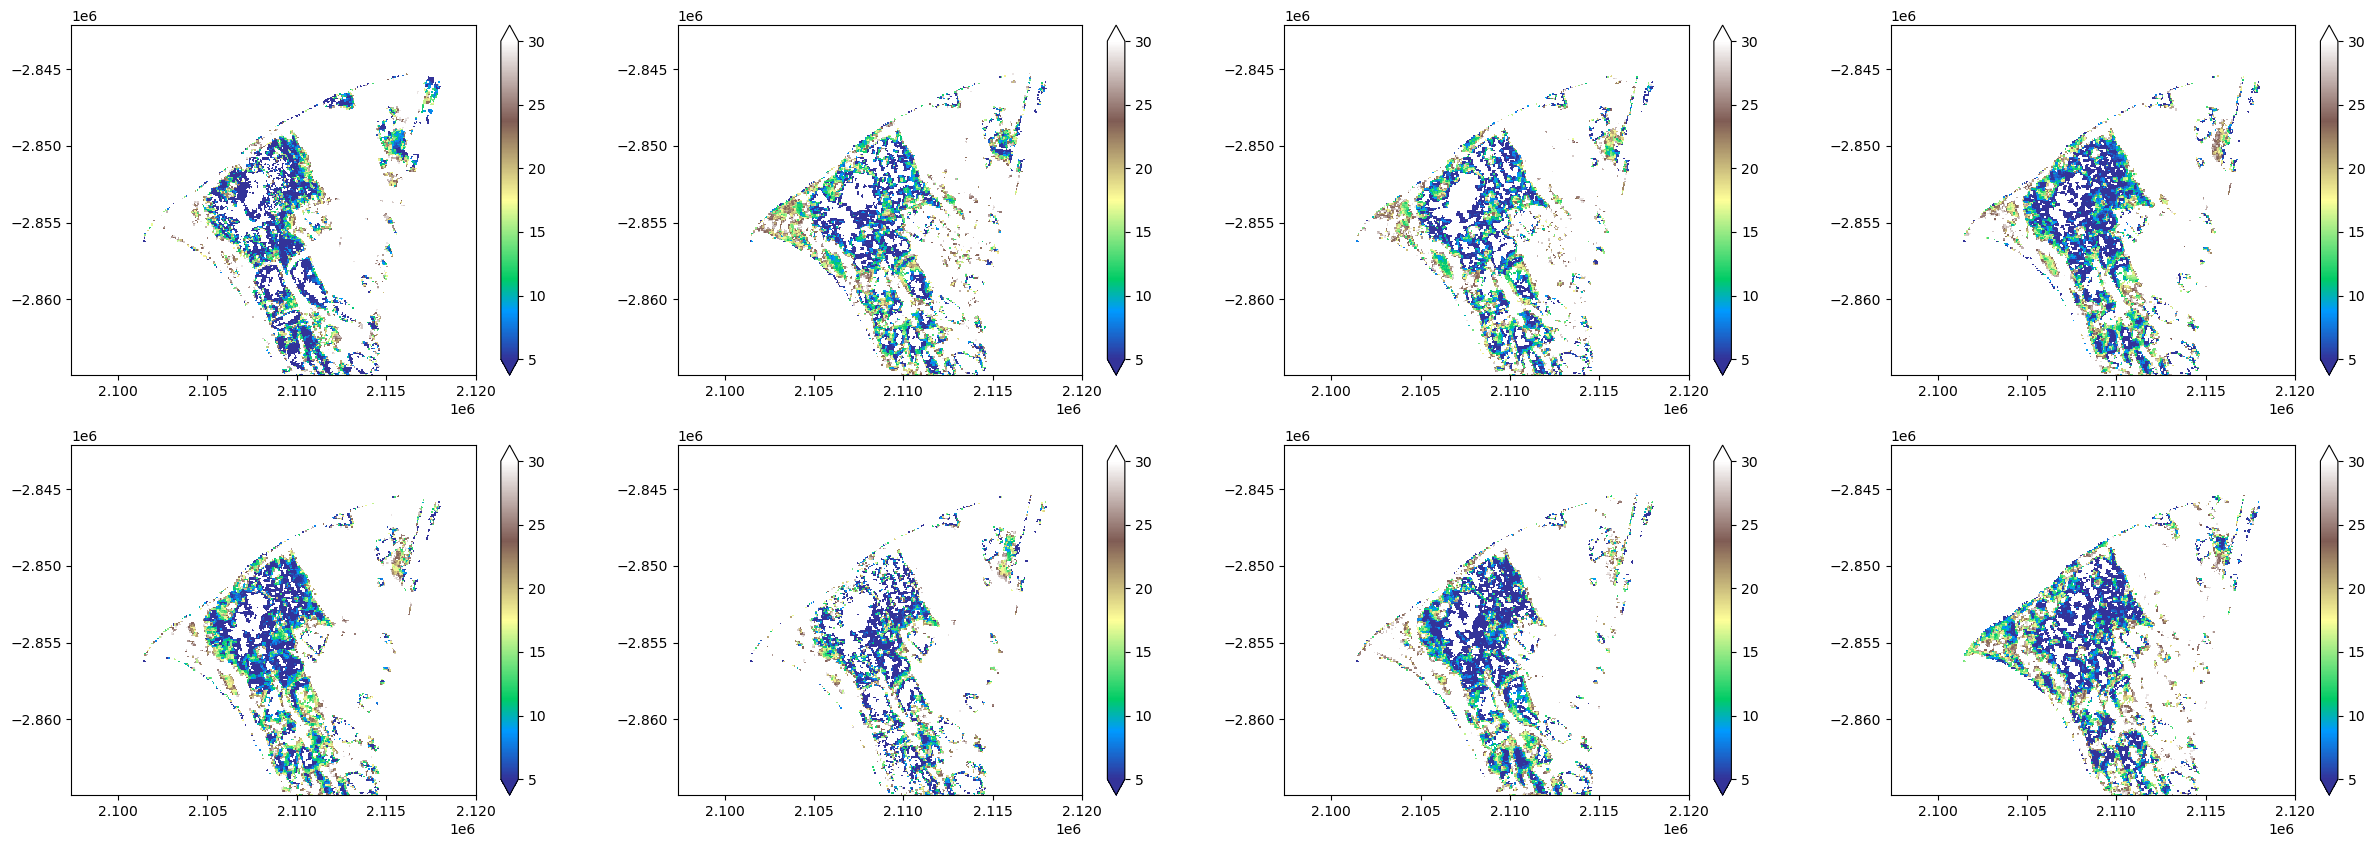

In [10]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)

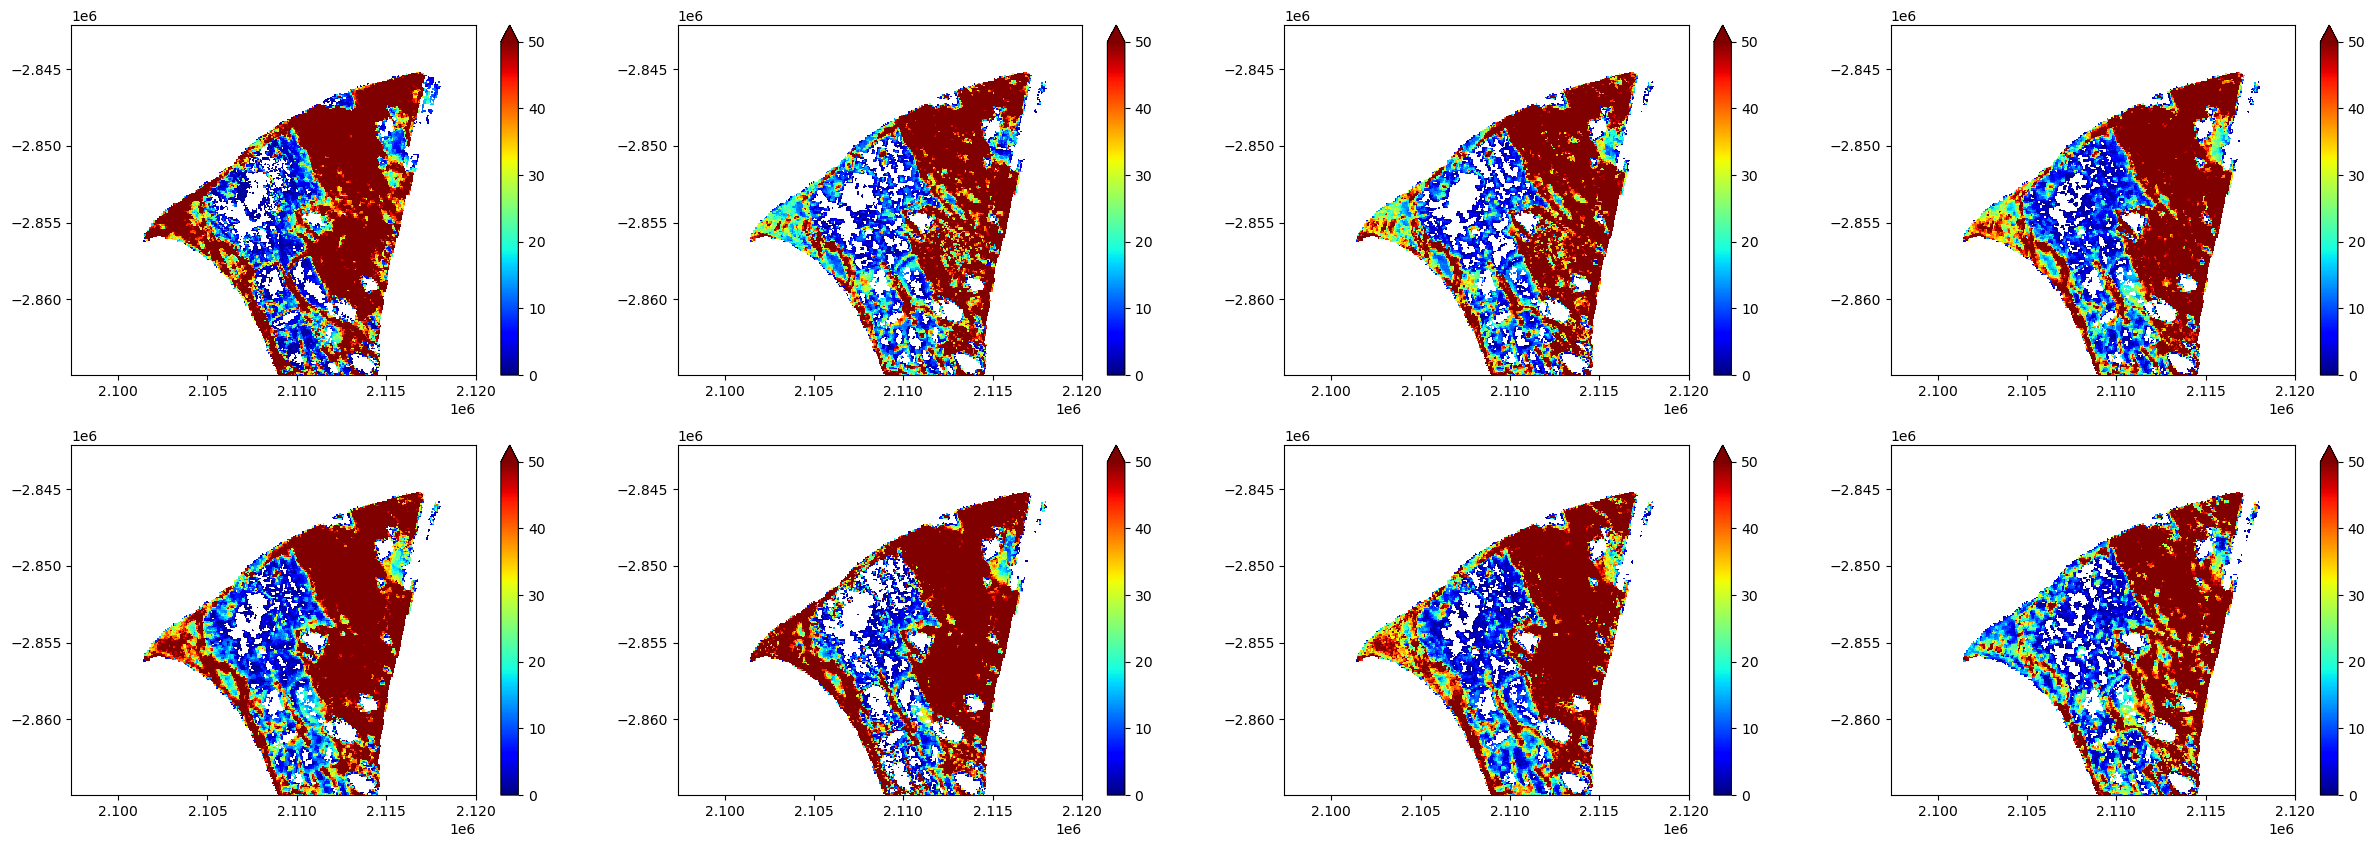

In [11]:
SD_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
SD.SD2010.plot(ax=axs[0,0], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2015.plot(ax=axs[0,1], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2016.plot(ax=axs[0,2], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2017.plot(ax=axs[0,3], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2018.plot(ax=axs[1,0], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2019.plot(ax=axs[1,1], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2020.plot(ax=axs[1,2], cmap='jet', vmin = 0, vmax = 50, add_labels=False)
SD.SD2021.plot(ax=axs[1,3], cmap='jet', vmin = 0, vmax = 50, add_labels=False)

In [12]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`